In [7]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta

from cartopy.crs import PlateCarree
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator, LongitudeLocator)
import cartopy.feature as cfeature


import matplotlib.ticker as mticker
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib.colors import Normalize

from sklearn.cluster import DBSCAN

import warnings
warnings.filterwarnings("ignore")


In [8]:
def import_data(fname):
    return xr.open_dataset(fname)

def time_preprocess(data):
    data["time"] = data["time"].dt.strftime("%Y-%m-%d").astype(np.datetime64)
    return data

def extract_lonlats(data):
    global lons, lats
    lons = data.lon
    lats = data.lat
    return lons, lats

def select_date(data, date):
    return data.sel(time = date)

def interpolate_data(data, lons, lats, method = "nearest"):
    data_interp = data.interp(lon = lons, lat = lats, method = method)
    return data_interp

def bathymetry_filter(data, bath, h = -1000):
    bath = interpolate_data(bath, lons, lats)
    data_filt = xr.where(bath.elevation < h, data, np.nan)
    return data_filt

def compute_anomalies(data, mean, std):
    return (data - mean)/std

############################### PLOTTING FUNCTIONS ####################
def make_grid(ax, font_size):
        gl = ax.gridlines(linewidth=1, color='gray', alpha=0.5,
                    linestyle='--',draw_labels=True)
        gl.xlabels_top = False
        gl.ylabels_right = False

        gl.xlabel_style = {'fontsize': font_size}
        gl.ylabel_style = {'fontsize': font_size}

        return gl

def set_plot(figsize = [7,7], nrows = 1, ncols = 1):
    fig, ax = plt.subplots(subplot_kw = dict(projection = PlateCarree()), figsize = figsize, nrows = nrows, ncols = ncols)
    
    font_size = 13
    if nrows == 1 and ncols == 1:
        ax.coastlines(resolution="10m", linewidths=0.5)
        ax.add_feature(cfeature.LAND.with_scale("10m"),
                edgecolor='lightgray',facecolor='lightgray',
                zorder=0)

        ax.tick_params(axis = "both", labelsize = font_size)

        gl = make_grid(ax, font_size)

    else:
        ax = ax.ravel()
        for a in ax:
            a.coastlines(resolution="10m", linewidths=0.5)
            a.add_feature(cfeature.LAND.with_scale("10m"),
                edgecolor='lightgray',facecolor='lightgray',
                zorder=0)

            a.tick_params(axis = "both", labelsize = font_size)
            gl = make_grid(a, font_size)

    return fig, ax

#####################################################################################

def labels_matrix(labels, chlorophyll):
    labels_matrix = np.empty(chlorophyll.shape)
    labels_matrix[:,:] = np.nan
    mask = ~np.isnan(chlorophyll)

    labels_matrix[mask] = labels.astype(int)
    return labels_matrix


def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

def preprocess_data(start_date, end_date):

    temperature = import_data("../data/SCS/CMEMS_temp_extended.nc").sel(time = [d.strftime("%Y-%m-%dT12:00:00") for d in daterange(start_date, end_date)]) \
                .analysed_sst.mean(axis = 0)

    lons, lats = extract_lonlats(temperature)


    chl = []
    for d in daterange(start_date, end_date):
        try:
            ch = import_data("../data/SCS/MODIS_DATA_DAILY/AQUA_MODIS.%s.L3m.DAY.CHL.x_chlor_a.nc"%(d.strftime("%Y%m%d"))).chlor_a
            chl.append(interpolate_data(ch, lons, lats))
        except:
            pass

    chlorophyll = np.nanmean(np.array(chl), axis = 0)

    return bathymetry_filter(chlorophyll, bathymetry).to_numpy(), bathymetry_filter(temperature, bathymetry).to_numpy()


In [9]:
global bathymetry
bathymetry = import_data("../data/SCS/bathymetry.nc")

In [10]:
bathymetry

<xarray.Dataset>
Dimensions:    (lat: 2400, lon: 1440)
Coordinates:
  * lat        (lat) float64 9.002 9.006 9.01 9.015 ... 18.99 18.99 18.99 19.0
  * lon        (lon) float64 108.0 108.0 108.0 108.0 ... 114.0 114.0 114.0 114.0
Data variables:
    elevation  (lat, lon) int16 ...
Attributes: (12/36)
    title:                           The GEBCO_2022 Grid - a continuous terra...
    summary:                         The GEBCO_2022 Grid is a continuous, glo...
    keywords:                        BATHYMETRY/SEAFLOOR TOPOGRAPHY, DIGITAL ...
    Conventions:                     CF-1.6, ACDD-1.3
    id:                              DOI: 10.5285/e0f0bb80-ab44-2739-e053-6c8...
    naming_authority:                https://dx.doi.org
    ...                              ...
    geospatial_vertical_units:       meters
    geospatial_vertical_resolution:  1.0
    geospatial_vertical_positive:    up
    identifier_product_doi:          DOI: 10.5285/e0f0bb80-ab44-2739-e053-6c8...
    references:                      DOI: 10.5285/e0f0bb80-ab44-2739-e053-6c8...
    node_offset:                     1.0

In [11]:
# CHLOROPHYLL
def chlorophyll_climatology(months, days):

    chlorophyll_clima = []
    for year in range(2003,2018):
        start_date = date(year, months[0], days[0])
        end_date = date(year, months[1], days[1])
        ch = []
        for single_date in daterange(start_date, end_date):
            fname = "../data/SCS/MODIS_DATA_DAILY/AQUA_MODIS.%s.L3m.DAY.CHL.x_chlor_a.nc"%(single_date.strftime("%Y%m%d"))
            try:
                a = interpolate_data(import_data(fname).chlor_a, lons, lats)
                ch.append(a.to_numpy())
            except:
                pass
        
        chlorophyll_clima.append(np.nanmean(ch, axis = 0))
    
    chlorophyll_std = bathymetry_filter(np.nanstd(np.array(chlorophyll_clima), axis = 0), bathymetry)
    chlorophyll_clima = bathymetry_filter(np.nanmean(np.array(chlorophyll_clima), axis = 0), bathymetry)

    return np.array(chlorophyll_clima), np.array(chlorophyll_std)


def temperature_clima(months, days):
    temp = import_data("../data/SCS/CMEMS_temp_extended.nc").groupby("time.dayofyear")
    
    temperature_std = bathymetry_filter(temp.std(axis = 0), bathymetry)
    temperature_clima = bathymetry_filter(temp.mean(axis = 0), bathymetry)

    return (temperature_clima), temperature_std


In [12]:
start_date = date(2005, 5, 17)
end_date = date(2005, 5, 25)

chlorophyll, temperature = preprocess_data(start_date, end_date)

chlorophyll_clima, chlorophyll_std = chlorophyll_climatology([5,5], [17,25])

In [13]:
chlorophyll.shape

(201, 121)

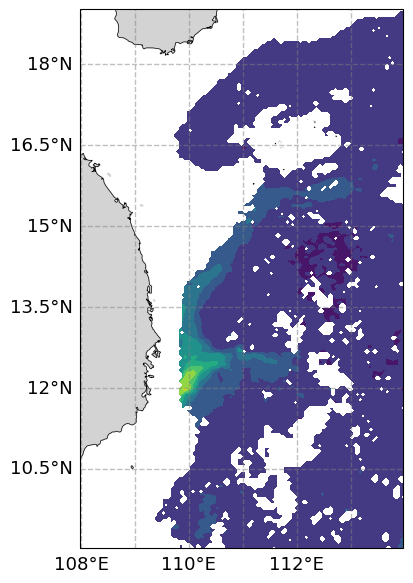

In [346]:
fig, ax = set_plot()
ax.contourf(lons, lats, chlorophyll)

In [347]:
temp_clima = []

temp = import_data("../data/SCS/CMEMS_temp_extended.nc")
t = []
for y in range(2003,2018):
    t.append(temp.sel(time = ["%s-05-%sT12:00:00"%(y, d) for d in range(17,25)]).analysed_sst.mean(dim = "time"))

temperature_std = bathymetry_filter(np.nanstd(t, axis = 0), bathymetry).to_numpy()
temperature_clima = bathymetry_filter(np.nanmean(t, axis = 0), bathymetry).to_numpy()



In [348]:
chlorophyll_anomalies = compute_anomalies(chlorophyll, chlorophyll_clima, chlorophyll_std)
temperature_anomalies = compute_anomalies(temperature, temperature_clima, temperature_std)

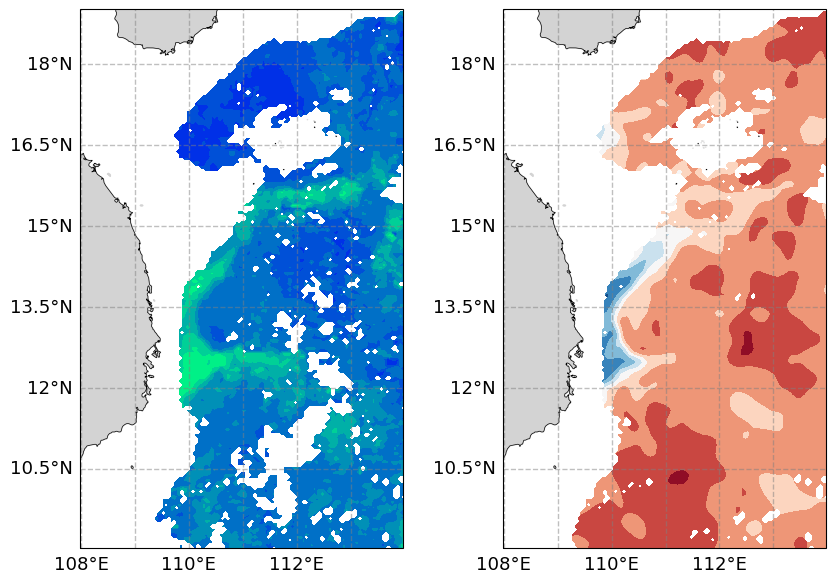

In [349]:
fig, ax = set_plot(ncols = 2, figsize = [10,7])

ax[0].contourf(lons, lats, chlorophyll_anomalies, cmap = "winter")
ax[1].contourf(lons, lats, temperature_anomalies, cmap = "RdBu_r")

In [350]:
def cluster_data(chl, temp):
    #temp = temperature[~np.isnan(temperature)]
    #chl = chlorophyll.to_numpy()[~np.isnan(temperature)]
    return np.array(list(zip(temp[~np.isnan(chl)], chl[~np.isnan(chl)])))

In [351]:
#chlorophyll_anomalies = interpolate_data(chlorophyll_anomalies, lons, lats)

data = cluster_data(chlorophyll_anomalies, temperature_anomalies)

In [352]:
labels = DBSCAN(eps=0.45, min_samples=1000).fit_predict(data)
plt.scatter(data[:,0], data[:,1], s = 3, c = labels)

KeyboardInterrupt: 

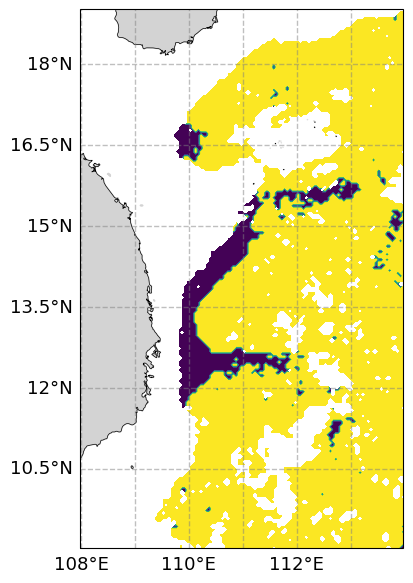

In [ ]:
labels_proj = labels_matrix(labels, chlorophyll_anomalies)
fig, ax = set_plot()
ax.contourf(lons, lats, labels_proj, 100, transform = PlateCarree())

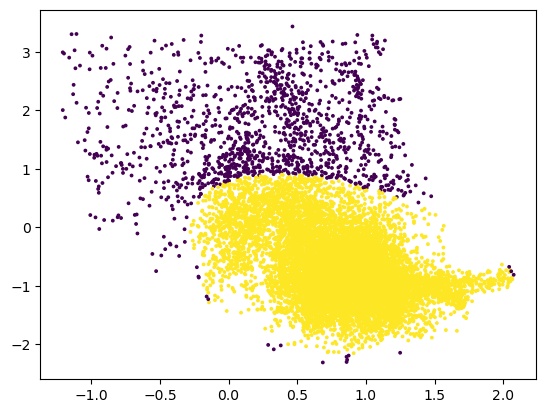

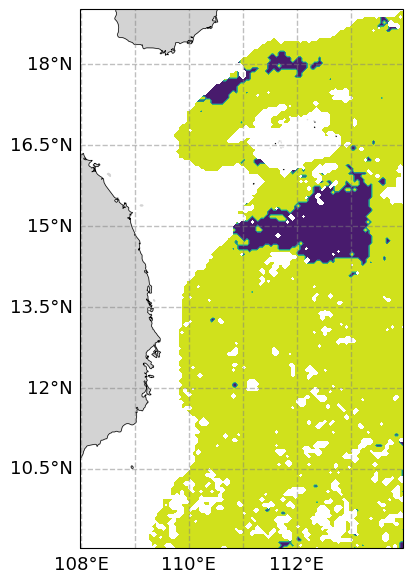

In [ ]:
start_date = date(2010, 5, 10)
end_date = date(2010, 5, 18)

chlorophyll, temperature = preprocess_data(start_date, end_date)


chlorophyll_clima, chlorophyll_std = chlorophyll_climatology([5,5], [10,18])
temp_clima = []

temp = import_data("../data/SCS/CMEMS_temp_extended.nc")
t = []
for y in range(2003,2018):
    t.append(temp.sel(time = ["%s-05-%sT12:00:00"%(y, d) for d in range(10,18)]).analysed_sst.mean(dim = "time"))

temperature_std = bathymetry_filter(np.nanstd(t, axis = 0), bathymetry).to_numpy()
temperature_clima = bathymetry_filter(np.nanmean(t, axis = 0), bathymetry).to_numpy()

chlorophyll_anomalies = compute_anomalies(chlorophyll, chlorophyll_clima, chlorophyll_std)
temperature_anomalies = compute_anomalies(temperature, temperature_clima, temperature_std)


data = cluster_data(chlorophyll_anomalies, temperature_anomalies)

labels = DBSCAN(eps=0.45, min_samples=1000).fit_predict(data)
plt.scatter(data[:,0], data[:,1], s = 3, c = labels)

labels_proj = labels_matrix(labels, chlorophyll_anomalies)
fig, ax = set_plot()
ax.contourf(lons, lats, labels_proj, transform = PlateCarree())

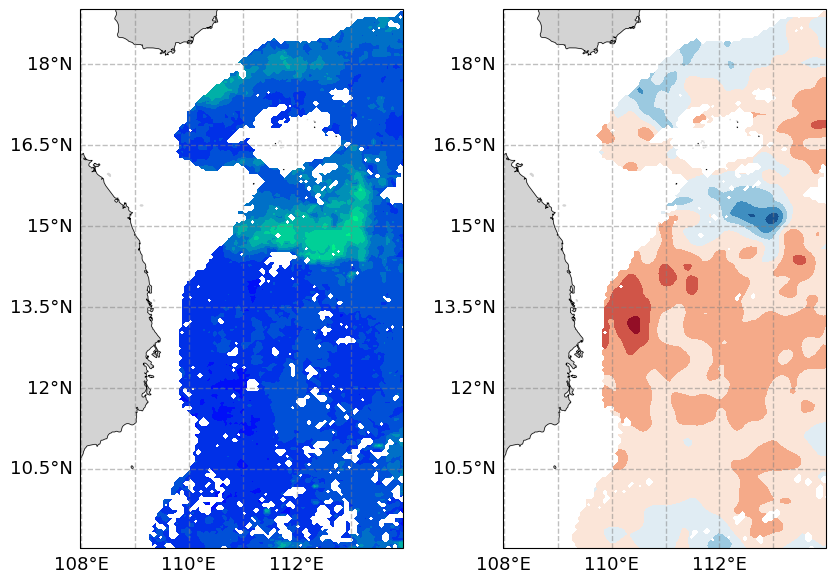

In [ ]:
fig, ax = set_plot(figsize = [10,7], ncols = 2)

ax[0].contourf(lons, lats, chlorophyll_anomalies, cmap = "winter")
ax[1].contourf(lons, lats, temperature_anomalies, cmap = "RdBu_r")

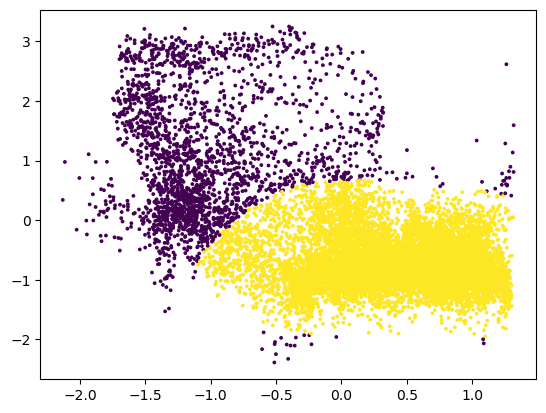

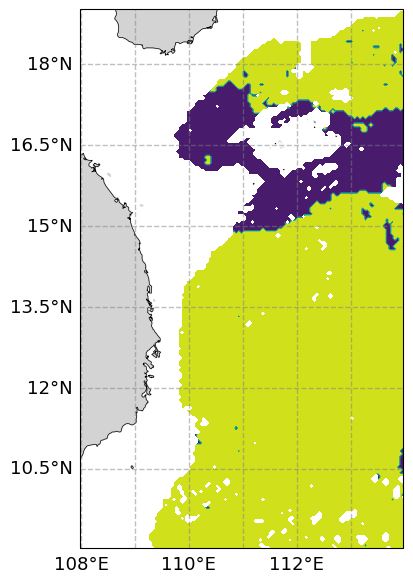

In [362]:
start_date = date(2015, 5, 10)
end_date = date(2015, 5, 18)

chlorophyll, temperature = preprocess_data(start_date, end_date)


chlorophyll_clima, chlorophyll_std = chlorophyll_climatology([5,5], [10,18])
temp_clima = []

temp = import_data("../data/SCS/CMEMS_temp_extended.nc")
t = []
for y in range(2003,2018):
    t.append(temp.sel(time = ["%s-05-%sT12:00:00"%(y, d) for d in range(10,18)]).analysed_sst.mean(dim = "time"))

temperature_std = bathymetry_filter(np.nanstd(t, axis = 0), bathymetry).to_numpy()
temperature_clima = bathymetry_filter(np.nanmean(t, axis = 0), bathymetry).to_numpy()

chlorophyll_anomalies = compute_anomalies(chlorophyll, chlorophyll_clima, chlorophyll_std)
temperature_anomalies = compute_anomalies(temperature, temperature_clima, temperature_std)


data = cluster_data(chlorophyll_anomalies, temperature_anomalies)

labels = DBSCAN(eps=0.5, min_samples=1000).fit_predict(data)
plt.scatter(data[:,0], data[:,1], s = 3, c = labels)

labels_proj = labels_matrix(labels, chlorophyll_anomalies)
fig, ax = set_plot()
ax.contourf(lons, lats, labels_proj, transform = PlateCarree())

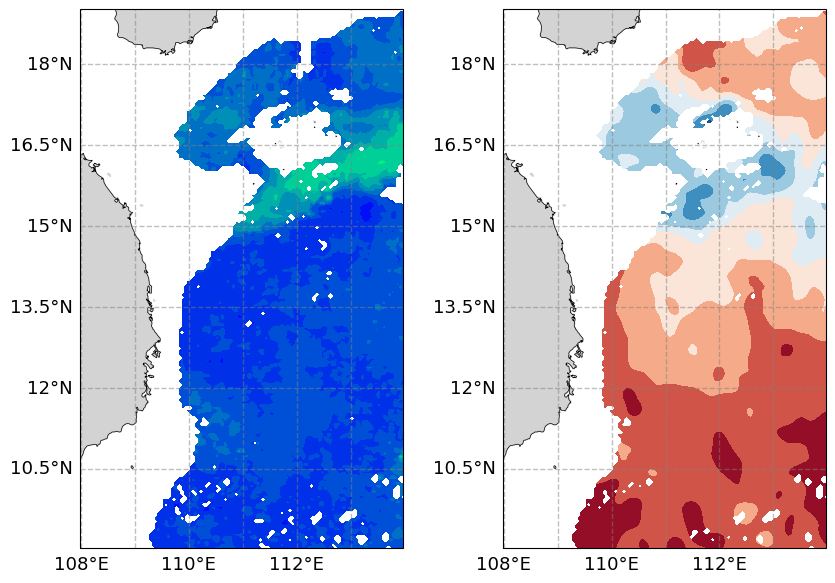

In [360]:
fig, ax = set_plot(figsize = [10,7], ncols = 2)

ax[0].contourf(lons, lats, chlorophyll_anomalies, cmap = "winter")
ax[1].contourf(lons, lats, temperature_anomalies, cmap = "RdBu_r")

In [ ]:
fig, ax = set_plot()

ax.contourf(lons, lats, bathymetry_filter(interpolate_data(import_data("../data/SCS/MODIS_DATA/AQUA_MODIS.20150509_20150516"))))

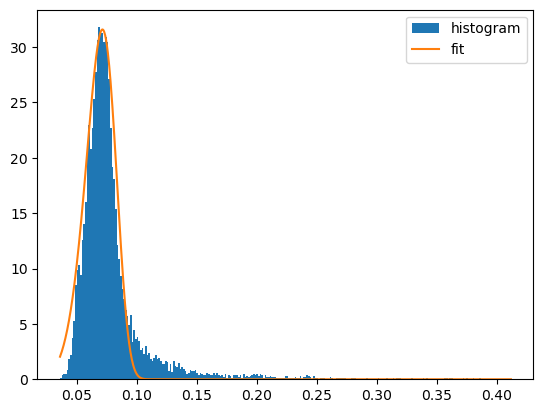

In [ ]:
from scipy.optimize import curve_fit
from scipy.stats import exponweib

def weibull(x, beta, eta):
    return beta/eta * (x/eta)**(beta - 1) * np.exp(-(x / eta)**beta)

bin_heights, bin_borders, _ = plt.hist(chlorophyll.flatten(), bins='auto', label='histogram', density = True)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 1000)
popt, _ = curve_fit(weibull, bin_centers, bin_heights)

plt.plot(x_interval_for_fit, weibull(x_interval_for_fit, *popt), label='fit')
plt.legend()

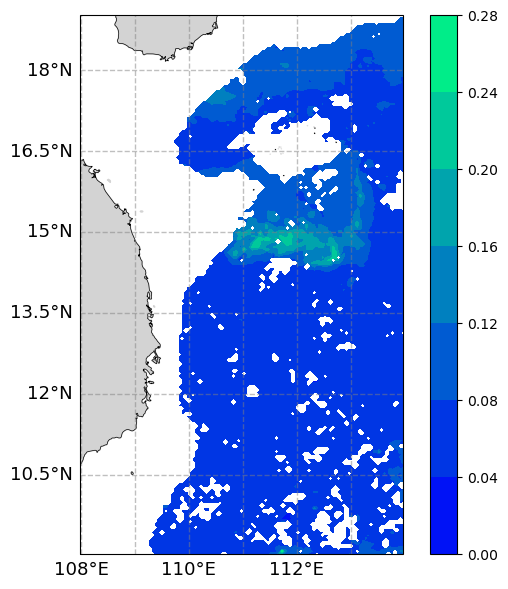

In [366]:
fig, ax = set_plot()
c = ax.contourf(lons, lats, bathymetry_filter(interpolate_data(import_data("../data/SCS/MODIS_DATA/AQUA_MODIS.20100509_20100516.L3m.8D.CHL.x_chlor_a.nc").chlor_a, lons, lats), bathymetry),
        cmap = "winter")

plt.colorbar(c, ax = ax)

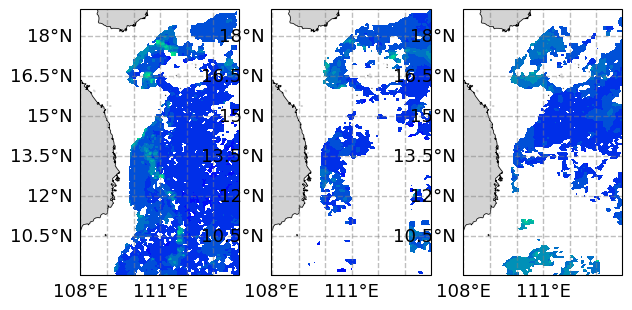

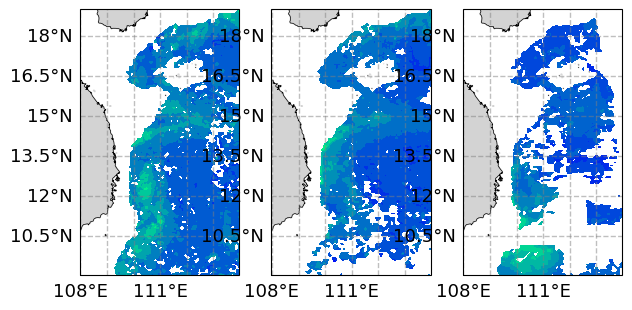

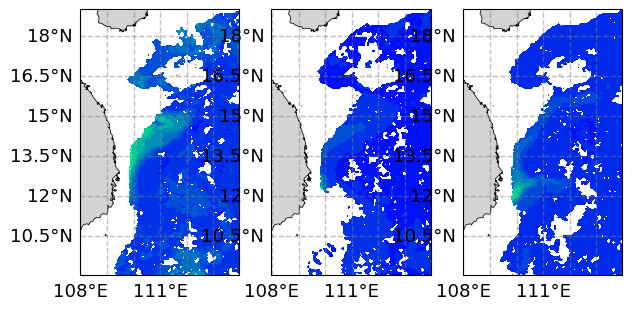

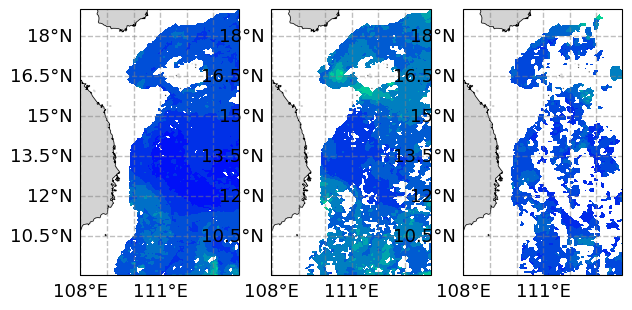

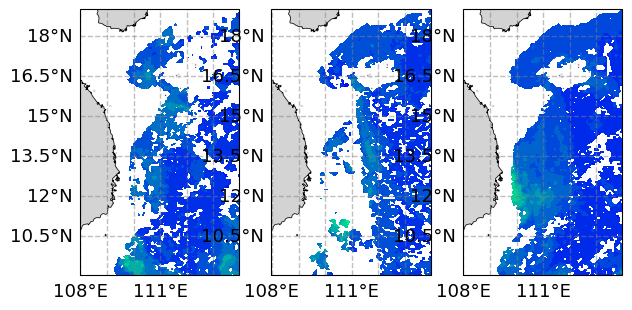

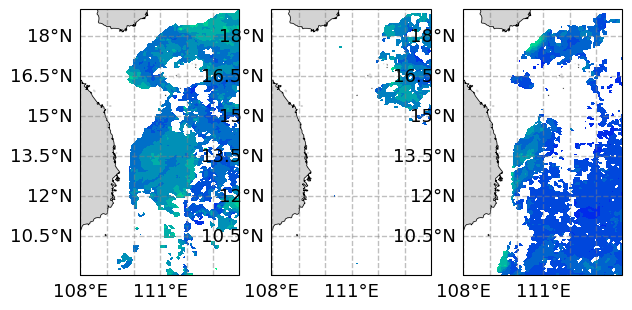

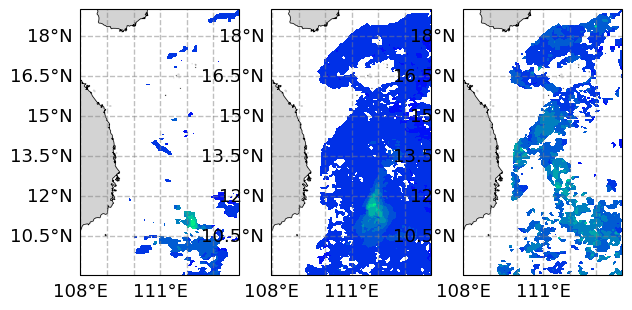

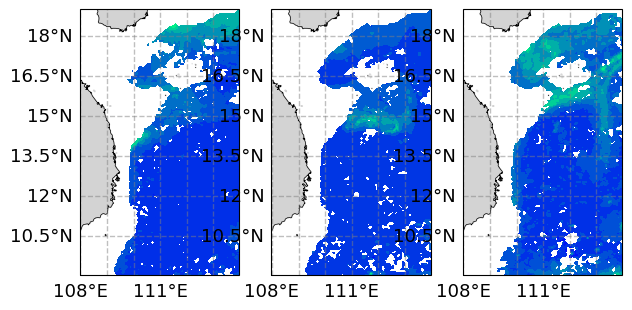

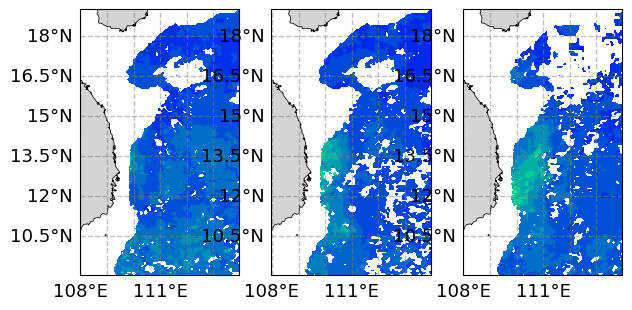

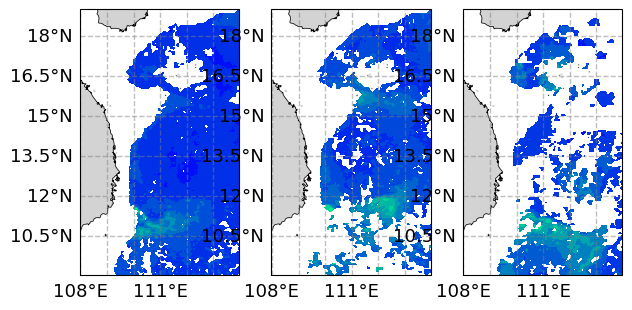

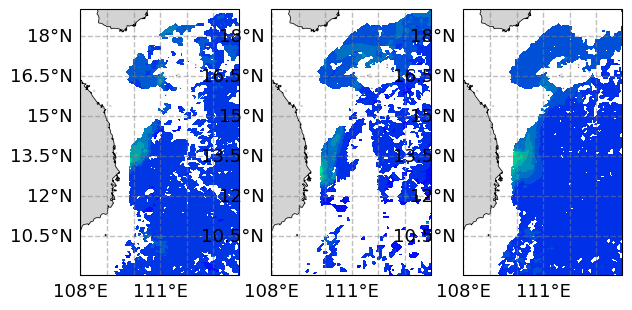

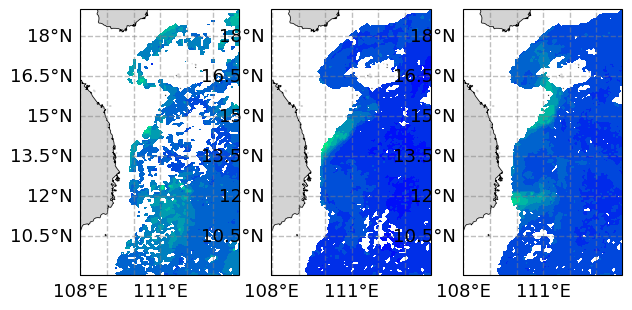

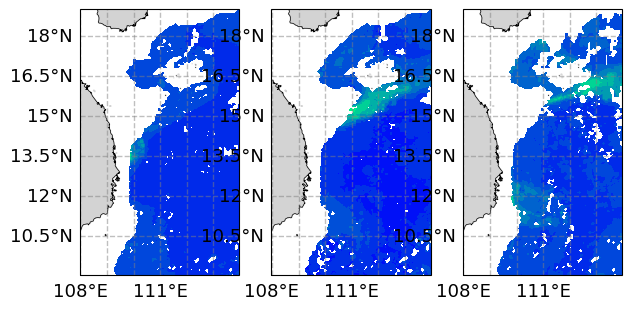

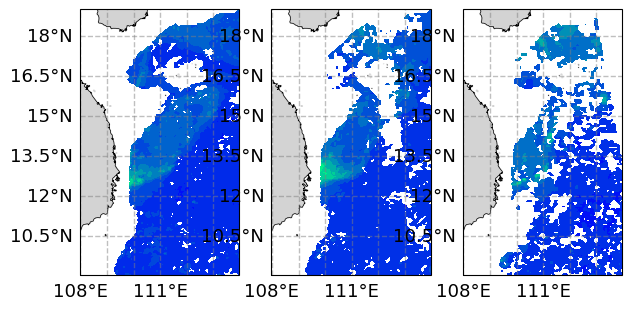

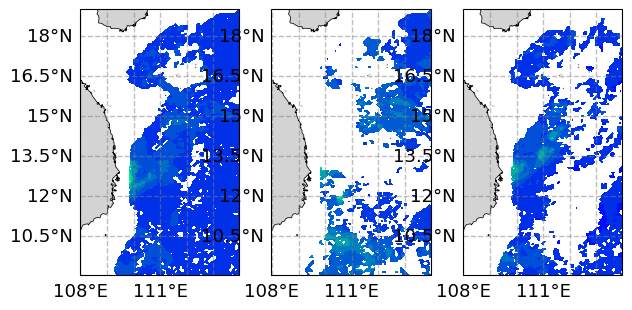

In [368]:

for y in range(2003,2018):
    fig, axs = set_plot(nrows = 1, ncols = 3)
    for (j, day) in enumerate(range(1, 25, 8)):
        start_date = date(y, 5, day)
        end_date = date(y, 5, day + 8)
        try:
            chlorophyll, _ = preprocess_data(start_date, end_date)
            axs[j].contourf(lons, lats, chlorophyll, cmap = "winter")
        except:
            pass



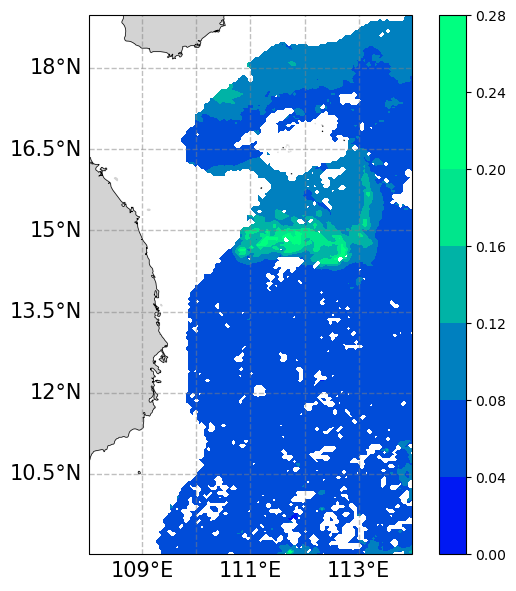

In [ ]:
fig, ax = set_plot()
c = ax.contourf(lons, lats, bathymetry_filter(import_data("../data/SCS/MODIS_DATA/AQUA_MODIS.20100509_20100516.L3m.8D.CHL.x_chlor_a.nc").chlor_a.to_numpy(), bathymetry),
        cmap = "winter", norm = Normalize(0,0.2) )

plt.colorbar(c, ax = ax)

In [ ]:
dates = ["%d-05-%d"%(year, day) for year in range(2003, 2018) for day in range(17,25)]

temperature_clima = time_preprocess(import_data("../data/SCS/CMEMS_temp_extended.nc")).sel(time = dates) \
    .analysed_sst.mean()

temperature_std = time_preprocess(import_data("../data/SCS/CMEMS_temp_extended.nc")).sel(time = dates) \
    .analysed_sst.std()

temperature = time_preprocess(import_data("../data/SCS/CMEMS_temp_extended.nc")).sel(time = ["2005-05-%d"%i for i in range(17,25)]).analysed_sst.mean(axis = 0)
bathymetry = import_data("../data/SCS/bathymetry.nc")

lons, lats = extract_lonlats(temperature)

chlorophyll = import_data("../data/SCS/MODIS_DATA/AQUA_MODIS.20100509_20100516.L3m.8D.CHL.x_chlor_a.nc").chlor_a

chlorophyll_clima = []

for year in range(2003, 2022):
    fname = "../data/SCS/MODIS_DATA/AQUA_MODIS." + str(year) + "0517" + "_" + str(year) + "0524.L3m.8D.CHL.x_chlor_a.nc"
    if (year - 2004)%4 == 0:
        fname = "../data/SCS/MODIS_DATA/AQUA_MODIS." + str(year) + "0516" + "_" + str(year) + "0523.L3m.8D.CHL.x_chlor_a.nc"
    
    chlorophyll_clima.append(import_data(fname).chlor_a.to_numpy())

chlorophyll_clima = np.array(chlorophyll_clima)
chlorophyll_std = np.nanstd(chlorophyll_clima, axis = 0)
chlorophyll_clima = np.nanmean(chlorophyll_clima, axis = 0)
chlorophyll_clima = bathymetry_filter(chlorophyll_clima, bathymetry)
chlorophyll_std = bathymetry_filter(chlorophyll_std, bathymetry)


bathymetry = interpolate_data(bathymetry, lons, lats)
chlorophyll, chlorophyll_clima, chlorophyll_std = interpolate_data(chlorophyll, lons, lats), interpolate_data(chlorophyll_clima, lons, lats), interpolate_data(chlorophyll_std, lons, lats)

temperature = bathymetry_filter(temperature, bathymetry)
chlorophyll = bathymetry_filter(chlorophyll, bathymetry)


ValueError: operands could not be broadcast together with shapes (2400,1440) (240,144) () 

In [381]:
#time_delta = date(2018, 1, 1)-date(2003, 1, 1)
start_date = date(2003,1,1)
end_date = date(2003,12,1)

list_of_file_names = []

for d in daterange(start_date, end_date):
    fname = "../data/SCS/MODIS_DATA_DAILY/AQUA_MODIS.%s.L3m.DAY.CHL.x_chlor_a.nc"%(d.strftime("%Y%m%d"))
    if os.path.exists(fname):
        list_of_file_names.append(fname)


all_data = xr.open_mfdataset(list_of_file_names)


ValueError: Could not find any dimension coordinates to use to order the datasets for concatenation

In [379]:
import os

os.path.exists("../data/SCS/MODIS_DATA_DAILY/AQUA_MODIS.%s.L3m.DAY.CHL.x_chlor_a.nc")

False

In [6]:
chlorophyll.

NameError: name 'chlorophyll' is not defined